In this notebook, we're going to work with an extended version of the "Heatlh Care for All" dataset will lots of new columns. We will start reviewing the manual data cleaning process for numerical, and categorical columns for some columns. Later, during the week we will cover automated ways to select the best subsets of columns to be used in our analysis.

# 7.01


# Loading libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Reading data

In [2]:
data = pd.read_csv('learningSet.csv')

C:\Users\chech\AppData\Local\Temp\ipykernel_31516\3673836359.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('learningSet.csv')


In [3]:
print(data.shape)
data.head()

(95412, 481)


,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,RECP3,RECPGVG,RECSWEEP,MDMAUD,DOMAIN,CLUSTER,AGE,AGEFLAG,HOMEOWNR,CHILD03,CHILD07,CHILD12,CHILD18,NUMCHLD,INCOME,GENDER,WEALTH1,HIT,MBCRAFT,MBGARDEN,MBBOOKS,MBCOLECT,MAGFAML,MAGFEM,MAGMALE,PUBGARDN,PUBCULIN,PUBHLTH,PUBDOITY,PUBNEWFN,PUBPHOTO,PUBOPP,DATASRCE,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,SOLP3,SOLIH,MAJOR,WEALTH2,GEOCODE,COLLECT1,VETERANS,BIBLE,CATLG,HOMEE,PETS,CDPLAY,STEREO,PCOWNERS,PHOTO,CRAFTS,FISHER,GARDENIN,BOATS,WALKER,KIDSTUFF,CARDS,PLATES,LIFESRC,PEPSTRFL,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,HHAGE1,HHAGE2,HHAGE3,HHN1,HHN2,HHN3,HHN4,HHN5,HHN6,MARR1,MARR2,MARR3,MARR4,HHP1,HHP2,DW1,DW2,DW3,DW4,DW5,DW6,DW7,DW8,DW9,HV1,HV2,HV3,HV4,HU1,HU2,HU3,HU4,HU5,HHD1,HHD2,HHD3,HHD4,HHD5,HHD6,HHD7,HHD8,HHD9,HHD10,HHD11,HHD12,ETHC1,ETHC2,ETHC3,ETHC4,ETHC5,ETHC6,HVP1,HVP2,HVP3,HVP4,HVP5,HVP6,HUR1,HUR2,RHP1,RHP2,RHP3,RHP4,HUPA1,HUPA2,HUPA3,HUPA4,HUPA5,HUPA6,HUPA7,RP1,RP2,RP3,RP4,MSA,ADI,DMA,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20,IC21,IC22,IC23,HHAS1,HHAS2,HHAS3,HHAS4,MC1,MC2,MC3,TPE1,TPE2,TPE3,TPE4,TPE5,TPE6,TPE7,TPE8,TPE9,PEC1,PEC2,TPE10,TPE11,TPE12,TPE13,LFC1,LFC2,LFC3,LFC4,LFC5,LFC6,LFC7,LFC8,LFC9,LFC10,OCC1,OCC2,OCC3,OCC4,OCC5,OCC6,OCC7,OCC8,OCC9,OCC10,OCC11,OCC12,OCC13,EIC1,EIC2,EIC3,EIC4,EIC5,EIC6,EIC7,EIC8,EIC9,EIC10,EIC11,EIC12,EIC13,EIC14,EIC15,EIC16,OEDC1,OEDC2,OEDC3,OEDC4,OEDC5,OEDC6,OEDC7,EC1,EC2,EC3,EC4,EC5,EC6,EC7,EC8,SEC1,SEC2,SEC3,SEC4,SEC5,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,VC1,VC2,VC3,VC4,ANC1,ANC2,ANC3,ANC4,ANC5,ANC6,ANC7,ANC8,ANC9,ANC10,ANC11,ANC12,ANC13,ANC14,ANC15,POBC1,POBC2,LSC1,LSC2,LSC3,LSC4,VOC1,VOC2,VOC3,HC1,HC2,HC3,HC4,HC5,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,ADATE_2,ADATE_3,ADATE_4,ADATE_5,ADATE_6,ADATE_7,ADATE_8,ADATE_9,ADATE_10,ADATE_11,ADATE_12,ADATE_13,ADATE_14,ADATE_15,ADATE_16,ADATE_17,ADATE_18,ADATE_19,ADATE_20,ADATE_21,ADATE_22,ADATE_23,ADATE_24,RFA_2,RFA_3,RFA_4,RFA_5,RFA_6,RFA_7,RFA_8,RFA_9,RFA_10,RFA_11,RFA_12,RFA_13,RFA_14,RFA_15,RFA_16,RFA_17,RFA_18,RFA_19,RFA_20,RFA_21,RFA_22,RFA_23,RFA_24,CARDPROM,MAXADATE,NUMPROM,CARDPM12,NUMPRM12,RDATE_3,RDATE_4,RDATE_5,RDATE_6,RDATE_7,RDATE_8,RDATE_9,RDATE_10,RDATE_11,RDATE_12,RDATE_13,RDATE_14,RDATE_15,RDATE_16,RDATE_17,RDATE_18,RDATE_19,RDATE_20,RDATE_21,RDATE_22,RDATE_23,RDATE_24,RAMNT_3,RAMNT_4,RAMNT_5,RAMNT_6,RAMNT_7,RAMNT_8,RAMNT_9,RAMNT_10,RAMNT_11,RAMNT_12,RAMNT_13,RAMNT_14,RAMNT_15,RAMNT_16,RAMNT_17,RAMNT_18,RAMNT_19,RAMNT_20,RAMNT_21,RAMNT_22,RAMNT_23,RAMNT_24,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MINRDATE,MAXRAMNT,MAXRDATE,LASTGIFT,LASTDATE,FISTDATE,NEXTDATE,TIMELAG,AVGGIFT,CONTROLN,TARGET_B,TARGET_D,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,CLUSTER2,GEOCODE2
0,8901,GRI,0,IL,61081,,,3712,0,,,,,XXXX,T2,36,60.0,,,,,,,NaN,NaN,F,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0,39,34,18,10,2,1,,,,5.0,,,,,,,,,,,,,,,,,,,,,X,992,264,332,0,35,65,47,53,92,1,0,0,11,0,0,0,0,0,0,0,11,0,0,0,39,48,51,40,50,54,25,31,42,27,11,14,18,17,13,11,15,12,11,34,25,18,26,10,23,18,33,49,28,12,4,61,7,12,19,198,276,97,95,2,2,0,0,7,7,0,479,635,3,2,86,14,96,4,7,38,80,70,32,84,16,6,2,5,9,15,3,17,50,25,0,0,0,2,7,13,27,47,0,1,61,58,61,15,4,2,0,0,14,1,0,0,2,5,17,73,0.0,177.0,682.0,307,318,349,378,12883,13,23,23,23,15,1,0,0,1,4,25,24,26,17,2,0,0,2,28,4,51,1,46,54,3,88,8,0,0,0,0,0,0,4,1,13,14,16,2,45,56,64,50,64,44,62,53,99,0,0,9,3,8,13,9,0,3,9,3,15,19,5,4,3,0,3,41,1,0,7,13,6,5,0,4,9,4,1,3,10,2,1,7,78,2,0,120,16,10,39,21,8,4,3,5,20,3,19,4,0,0,0,18,39,0,34,23,18,16,1,4,0,23,0,0,5,1,0,0,0,0,0,2,0,3,74,88,8,0,4,96,77,19,13,31,5,14,14,31,54,46,0,0,90,0,10,0,0,0,33,65,40,99,99,6,2,10,7,9706,9606.0,9604.0,9604.

Column "TARGET_B" encodes if the customer answered or not the call

In [4]:
data['TARGET_B'].value_counts()

0    90569
1     4843
Name: TARGET_B, dtype: int64

Column "TARGET_D" provide the donation amount.

In [5]:
data['TARGET_D'].describe()

count    95412.000000
mean         0.793073
std          4.429725
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        200.000000
Name: TARGET_D, dtype: float64

In [7]:
data[data['TARGET_B']>0]['TARGET_D'].describe()

count    4843.000000
mean       15.624344
std        12.445137
min         1.000000
25%        10.000000
50%        13.000000
75%        20.000000
max       200.000000
Name: TARGET_D, dtype: float64

To solve this problem we will first build a classification model to predict who will more likely respond and then for those respondents, we will build a regression model to predict the donation amount.

Then we can use the cost matrix to calculate the total benefit from the donations (remember that the company has to do a mailing champaing and each envelope costs some money).

Some of the challenges with the dataset are as follows:

* Large number of features: The data set has over 450 features. Hence selecting the right features for the model is very critical and at the same time it is not easy as the same traditional ways of removing features is not effective given the large number of features. Apart from feature selection, feature extraction (creating your own features using the existing features) is also not easy in this case.

* Sparsity of the dataset: There are a lot of features with a large number of null values.

* Data imbalance: For developing a classification, there is a huge imbalance in the training dataset with only approximately 5000 values for one category as compared to cover 95,000 instances for the other category.

# Review data cleaning process

There are a lot of columns that have a very high percentage of null values. It is a highly sparse dataset.
We can decide on a threshold and then remove those variables. There is no rule of thumb to decide on this threshold value.
Sometimes it can as low as 25%-30%. And sometimes in some data sets you might find that even though there are more than 50% missing values in a column, you might have to include that variable in your analysis.
A lot of it depends on the business context as well. In this case we will take this threshold to be 25% and then check the definitions of the columns filtered, to see if there is any column that we might want to keep.

In [8]:
data.shape[0]

95412

In [9]:
len(data)

95412

In [10]:
nulls_percent_df = pd.DataFrame(data.isna().sum()/len(data)).reset_index()
nulls_percent_df.columns = ['column_name', 'nulls_percentage']
nulls_percent_df

,column_name,nulls_percentage
0,ODATEDW,0.000000
1,OSOURCE,0.000000
2,TCODE,0.000000
3,STATE,0.000000
4,ZIP,0.000000
...,...,...
476,MDMAUD_R,0.000000
477,MDMAUD_F,0.000000
478,MDMAUD_A,0.000000
479,CLUSTER2,0.001383


Which columns have NA's?

In [11]:
nulls_percent_df[nulls_percent_df['nulls_percentage']!=0]

,column_name,nulls_percentage
16,AGE,0.248030
23,NUMCHLD,0.870184
24,INCOME,0.223096
26,WEALTH1,0.468830
28,MBCRAFT,0.553955
...,...,...
455,RAMNT_24,0.814090
466,NEXTDATE,0.104526
467,TIMELAG,0.104526
479,CLUSTER2,0.001383


In [12]:
columns_above_threshold = nulls_percent_df[nulls_percent_df['nulls_percentage']>0.25]
columns_above_threshold['column_name']

23      NUMCHLD
26      WEALTH1
28      MBCRAFT
29     MBGARDEN
30      MBBOOKS
         ...   
451    RAMNT_20
452    RAMNT_21
453    RAMNT_22
454    RAMNT_23
455    RAMNT_24
Name: column_name, Length: 72, dtype: object

In [13]:
drop_columns_list = list(columns_above_threshold['column_name'])
print(drop_columns_list)

['NUMCHLD', 'WEALTH1', 'MBCRAFT', 'MBGARDEN', 'MBBOOKS', 'MBCOLECT', 'MAGFAML', 'MAGFEM', 'MAGMALE', 'PUBGARDN', 'PUBCULIN', 'PUBHLTH', 'PUBDOITY', 'PUBNEWFN', 'PUBPHOTO', 'PUBOPP', 'WEALTH2', 'ADATE_5', 'ADATE_10', 'ADATE_13', 'ADATE_15', 'ADATE_17', 'ADATE_19', 'ADATE_20', 'ADATE_21', 'ADATE_22', 'ADATE_23', 'ADATE_24', 'RDATE_3', 'RDATE_4', 'RDATE_5', 'RDATE_6', 'RDATE_7', 'RDATE_8', 'RDATE_9', 'RDATE_10', 'RDATE_11', 'RDATE_12', 'RDATE_13', 'RDATE_14', 'RDATE_15', 'RDATE_16', 'RDATE_17', 'RDATE_18', 'RDATE_19', 'RDATE_20', 'RDATE_21', 'RDATE_22', 'RDATE_23', 'RDATE_24', 'RAMNT_3', 'RAMNT_4', 'RAMNT_5', 'RAMNT_6', 'RAMNT_7', 'RAMNT_8', 'RAMNT_9', 'RAMNT_10', 'RAMNT_11', 'RAMNT_12', 'RAMNT_13', 'RAMNT_14', 'RAMNT_15', 'RAMNT_16', 'RAMNT_17', 'RAMNT_18', 'RAMNT_19', 'RAMNT_20', 'RAMNT_21', 'RAMNT_22', 'RAMNT_23', 'RAMNT_24']


From the list above that includes the columns that have over 25% null values, you discussed with your manager you were told that the following columns are important -> **wealth1, wealth2**
We will remove these variables from the above list
RDATE3, RAMNT_3 are important but they have too many null values

# Activity

Create a function that takes a dataframe as an input and a percentual threshold (default value = 0.25) and returns a list of columns with null values greater than the specified threshold

In [14]:
def remove_cols_with_na(df: pd.DataFrame, thr = 0.25)-> list:
    nulls_percent_df = pd.DataFrame(df.isna().sum()/len(data)).reset_index()
    nulls_percent_df.columns = ['column_name', 'nulls_percentage']
    return list(nulls_percent_df[nulls_percent_df['nulls_percentage'] > thr]['column_name'].values)

In [15]:
remove_cols_with_na(data, 0.25)

['NUMCHLD',
 'WEALTH1',
 'MBCRAFT',
 'MBGARDEN',
 'MBBOOKS',
 'MBCOLECT',
 'MAGFAML',
 'MAGFEM',
 'MAGMALE',
 'PUBGARDN',
 'PUBCULIN',
 'PUBHLTH',
 'PUBDOITY',
 'PUBNEWFN',
 'PUBPHOTO',
 'PUBOPP',
 'WEALTH2',
 'ADATE_5',
 'ADATE_10',
 'ADATE_13',
 'ADATE_15',
 'ADATE_17',
 'ADATE_19',
 'ADATE_20',
 'ADATE_21',
 'ADATE_22',
 'ADATE_23',
 'ADATE_24',
 'RDATE_3',
 'RDATE_4',
 'RDATE_5',
 'RDATE_6',
 'RDATE_7',
 'RDATE_8',
 'RDATE_9',
 'RDATE_10',
 'RDATE_11',
 'RDATE_12',
 'RDATE_13',
 'RDATE_14',
 'RDATE_15',
 'RDATE_16',
 'RDATE_17',
 'RDATE_18',
 'RDATE_19',
 'RDATE_20',
 'RDATE_21',
 'RDATE_22',
 'RDATE_23',
 'RDATE_24',
 'RAMNT_3',
 'RAMNT_4',
 'RAMNT_5',
 'RAMNT_6',
 'RAMNT_7',
 'RAMNT_8',
 'RAMNT_9',
 'RAMNT_10',
 'RAMNT_11',
 'RAMNT_12',
 'RAMNT_13',
 'RAMNT_14',
 'RAMNT_15',
 'RAMNT_16',
 'RAMNT_17',
 'RAMNT_18',
 'RAMNT_19',
 'RAMNT_20',
 'RAMNT_21',
 'RAMNT_22',
 'RAMNT_23',
 'RAMNT_24']

In [16]:
# End of the activity

# More data cleaning

In [17]:
data.head()

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,RECP3,RECPGVG,RECSWEEP,MDMAUD,DOMAIN,CLUSTER,AGE,AGEFLAG,HOMEOWNR,CHILD03,CHILD07,CHILD12,CHILD18,NUMCHLD,INCOME,GENDER,WEALTH1,HIT,MBCRAFT,MBGARDEN,MBBOOKS,MBCOLECT,MAGFAML,MAGFEM,MAGMALE,PUBGARDN,PUBCULIN,PUBHLTH,PUBDOITY,PUBNEWFN,PUBPHOTO,PUBOPP,DATASRCE,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,SOLP3,SOLIH,MAJOR,WEALTH2,GEOCODE,COLLECT1,VETERANS,BIBLE,CATLG,HOMEE,PETS,CDPLAY,STEREO,PCOWNERS,PHOTO,CRAFTS,FISHER,GARDENIN,BOATS,WALKER,KIDSTUFF,CARDS,PLATES,LIFESRC,PEPSTRFL,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,HHAGE1,HHAGE2,HHAGE3,HHN1,HHN2,HHN3,HHN4,HHN5,HHN6,MARR1,MARR2,MARR3,MARR4,HHP1,HHP2,DW1,DW2,DW3,DW4,DW5,DW6,DW7,DW8,DW9,HV1,HV2,HV3,HV4,HU1,HU2,HU3,HU4,HU5,HHD1,HHD2,HHD3,HHD4,HHD5,HHD6,HHD7,HHD8,HHD9,HHD10,HHD11,HHD12,ETHC1,ETHC2,ETHC3,ETHC4,ETHC5,ETHC6,HVP1,HVP2,HVP3,HVP4,HVP5,HVP6,HUR1,HUR2,RHP1,RHP2,RHP3,RHP4,HUPA1,HUPA2,HUPA3,HUPA4,HUPA5,HUPA6,HUPA7,RP1,RP2,RP3,RP4,MSA,ADI,DMA,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20,IC21,IC22,IC23,HHAS1,HHAS2,HHAS3,HHAS4,MC1,MC2,MC3,TPE1,TPE2,TPE3,TPE4,TPE5,TPE6,TPE7,TPE8,TPE9,PEC1,PEC2,TPE10,TPE11,TPE12,TPE13,LFC1,LFC2,LFC3,LFC4,LFC5,LFC6,LFC7,LFC8,LFC9,LFC10,OCC1,OCC2,OCC3,OCC4,OCC5,OCC6,OCC7,OCC8,OCC9,OCC10,OCC11,OCC12,OCC13,EIC1,EIC2,EIC3,EIC4,EIC5,EIC6,EIC7,EIC8,EIC9,EIC10,EIC11,EIC12,EIC13,EIC14,EIC15,EIC16,OEDC1,OEDC2,OEDC3,OEDC4,OEDC5,OEDC6,OEDC7,EC1,EC2,EC3,EC4,EC5,EC6,EC7,EC8,SEC1,SEC2,SEC3,SEC4,SEC5,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,VC1,VC2,VC3,VC4,ANC1,ANC2,ANC3,ANC4,ANC5,ANC6,ANC7,ANC8,ANC9,ANC10,ANC11,ANC12,ANC13,ANC14,ANC15,POBC1,POBC2,LSC1,LSC2,LSC3,LSC4,VOC1,VOC2,VOC3,HC1,HC2,HC3,HC4,HC5,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,ADATE_2,ADATE_3,ADATE_4,ADATE_5,ADATE_6,ADATE_7,ADATE_8,ADATE_9,ADATE_10,ADATE_11,ADATE_12,ADATE_13,ADATE_14,ADATE_15,ADATE_16,ADATE_17,ADATE_18,ADATE_19,ADATE_20,ADATE_21,ADATE_22,ADATE_23,ADATE_24,RFA_2,RFA_3,RFA_4,RFA_5,RFA_6,RFA_7,RFA_8,RFA_9,RFA_10,RFA_11,RFA_12,RFA_13,RFA_14,RFA_15,RFA_16,RFA_17,RFA_18,RFA_19,RFA_20,RFA_21,RFA_22,RFA_23,RFA_24,CARDPROM,MAXADATE,NUMPROM,CARDPM12,NUMPRM12,RDATE_3,RDATE_4,RDATE_5,RDATE_6,RDATE_7,RDATE_8,RDATE_9,RDATE_10,RDATE_11,RDATE_12,RDATE_13,RDATE_14,RDATE_15,RDATE_16,RDATE_17,RDATE_18,RDATE_19,RDATE_20,RDATE_21,RDATE_22,RDATE_23,RDATE_24,RAMNT_3,RAMNT_4,RAMNT_5,RAMNT_6,RAMNT_7,RAMNT_8,RAMNT_9,RAMNT_10,RAMNT_11,RAMNT_12,RAMNT_13,RAMNT_14,RAMNT_15,RAMNT_16,RAMNT_17,RAMNT_18,RAMNT_19,RAMNT_20,RAMNT_21,RAMNT_22,RAMNT_23,RAMNT_24,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MINRDATE,MAXRAMNT,MAXRDATE,LASTGIFT,LASTDATE,FISTDATE,NEXTDATE,TIMELAG,AVGGIFT,CONTROLN,TARGET_B,TARGET_D,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,CLUSTER2,GEOCODE2
0,8901,GRI,0,IL,61081,,,3712,0,,,,,XXXX,T2,36,60.0,,,,,,,NaN,NaN,F,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0,39,34,18,10,2,1,,,,5.0,,,,,,,,,,,,,,,,,,,,,X,992,264,332,0,35,65,47,53,92,1,0,0,11,0,0,0,0,0,0,0,11,0,0,0,39,48,51,40,50,54,25,31,42,27,11,14,18,17,13,11,15,12,11,34,25,18,26,10,23,18,33,49,28,12,4,61,7,12,19,198,276,97,95,2,2,0,0,7,7,0,479,635,3,2,86,14,96,4,7,38,80,70,32,84,16,6,2,5,9,15,3,17,50,25,0,0,0,2,7,13,27,47,0,1,61,58,61,15,4,2,0,0,14,1,0,0,2,5,17,73,0.0,177.0,682.0,307,318,349,378,12883,13,23,23,23,15,1,0,0,1,4,25,24,26,17,2,0,0,2,28,4,51,1,46,54,3,88,8,0,0,0,0,0,0,4,1,13,14,16,2,45,56,64,50,64,44,62,53,99,0,0,9,3,8,13,9,0,3,9,3,15,19,5,4,3,0,3,41,1,0,7,13,6,5,0,4,9,4,1,3,10,2,1,7,78,2,0,120,16,10,39,21,8,4,3,5,20,3,19,4,0,0,0,18,39,0,34,23,18,16,1,4,0,23,0,0,5,1,0,0,0,0,0,2,0,3,74,88,8,0,4,96,77,19,13,31,5,14,14,31,54,46,0,0,90,0,10,0,0,0,33,65,40,99,99,6,2,10,7,9706,9606.0,9604.0,9604.

We can see that there are a lot of columns that have blank spaces which represent no value in this case.
They were not identified as null values by python as they are empty spaces that are read as character values by
python. We will replace those values by NaNs and repeat the analysis

Before we do that we will replace the blank values from the column "MAILCODE" by "A" which would mean the address is okay (pl check the definition of the variable in the description)

In [18]:
data['MAILCODE'].value_counts()

     94013
B     1399
Name: MAILCODE, dtype: int64

In [19]:
data['MAILCODE'].unique()

array([' ', 'B'], dtype=object)

In [20]:
data['MAILCODE'] = data['MAILCODE'].apply(lambda x: x.replace(" ", "A"))
#data['MAILCODE'] = np.where(data['MAILCODE'] == " ", "A",data['MAILCODE'] )
#data['MAILCODE'] = data['MAILCODE'].apply(lambda x: x if (x != " ") else "A")
# function(arg1)
#df[col] = list(map(function,df[col]))
# function(arg1, arg2, arg3)
#df[col] = list(map(function,df[col],[arg2]*len(df), [arg3]*len(df)))

In [21]:
# Now we can replace the rest space characters with np.NaN

In [22]:
data = data.apply(lambda x: x.replace(" ", np.NaN))

In [23]:
data.head()

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,RECP3,RECPGVG,RECSWEEP,MDMAUD,DOMAIN,CLUSTER,AGE,AGEFLAG,HOMEOWNR,CHILD03,CHILD07,CHILD12,CHILD18,NUMCHLD,INCOME,GENDER,WEALTH1,HIT,MBCRAFT,MBGARDEN,MBBOOKS,MBCOLECT,MAGFAML,MAGFEM,MAGMALE,PUBGARDN,PUBCULIN,PUBHLTH,PUBDOITY,PUBNEWFN,PUBPHOTO,PUBOPP,DATASRCE,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,SOLP3,SOLIH,MAJOR,WEALTH2,GEOCODE,COLLECT1,VETERANS,BIBLE,CATLG,HOMEE,PETS,CDPLAY,STEREO,PCOWNERS,PHOTO,CRAFTS,FISHER,GARDENIN,BOATS,WALKER,KIDSTUFF,CARDS,PLATES,LIFESRC,PEPSTRFL,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,HHAGE1,HHAGE2,HHAGE3,HHN1,HHN2,HHN3,HHN4,HHN5,HHN6,MARR1,MARR2,MARR3,MARR4,HHP1,HHP2,DW1,DW2,DW3,DW4,DW5,DW6,DW7,DW8,DW9,HV1,HV2,HV3,HV4,HU1,HU2,HU3,HU4,HU5,HHD1,HHD2,HHD3,HHD4,HHD5,HHD6,HHD7,HHD8,HHD9,HHD10,HHD11,HHD12,ETHC1,ETHC2,ETHC3,ETHC4,ETHC5,ETHC6,HVP1,HVP2,HVP3,HVP4,HVP5,HVP6,HUR1,HUR2,RHP1,RHP2,RHP3,RHP4,HUPA1,HUPA2,HUPA3,HUPA4,HUPA5,HUPA6,HUPA7,RP1,RP2,RP3,RP4,MSA,ADI,DMA,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20,IC21,IC22,IC23,HHAS1,HHAS2,HHAS3,HHAS4,MC1,MC2,MC3,TPE1,TPE2,TPE3,TPE4,TPE5,TPE6,TPE7,TPE8,TPE9,PEC1,PEC2,TPE10,TPE11,TPE12,TPE13,LFC1,LFC2,LFC3,LFC4,LFC5,LFC6,LFC7,LFC8,LFC9,LFC10,OCC1,OCC2,OCC3,OCC4,OCC5,OCC6,OCC7,OCC8,OCC9,OCC10,OCC11,OCC12,OCC13,EIC1,EIC2,EIC3,EIC4,EIC5,EIC6,EIC7,EIC8,EIC9,EIC10,EIC11,EIC12,EIC13,EIC14,EIC15,EIC16,OEDC1,OEDC2,OEDC3,OEDC4,OEDC5,OEDC6,OEDC7,EC1,EC2,EC3,EC4,EC5,EC6,EC7,EC8,SEC1,SEC2,SEC3,SEC4,SEC5,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,VC1,VC2,VC3,VC4,ANC1,ANC2,ANC3,ANC4,ANC5,ANC6,ANC7,ANC8,ANC9,ANC10,ANC11,ANC12,ANC13,ANC14,ANC15,POBC1,POBC2,LSC1,LSC2,LSC3,LSC4,VOC1,VOC2,VOC3,HC1,HC2,HC3,HC4,HC5,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,ADATE_2,ADATE_3,ADATE_4,ADATE_5,ADATE_6,ADATE_7,ADATE_8,ADATE_9,ADATE_10,ADATE_11,ADATE_12,ADATE_13,ADATE_14,ADATE_15,ADATE_16,ADATE_17,ADATE_18,ADATE_19,ADATE_20,ADATE_21,ADATE_22,ADATE_23,ADATE_24,RFA_2,RFA_3,RFA_4,RFA_5,RFA_6,RFA_7,RFA_8,RFA_9,RFA_10,RFA_11,RFA_12,RFA_13,RFA_14,RFA_15,RFA_16,RFA_17,RFA_18,RFA_19,RFA_20,RFA_21,RFA_22,RFA_23,RFA_24,CARDPROM,MAXADATE,NUMPROM,CARDPM12,NUMPRM12,RDATE_3,RDATE_4,RDATE_5,RDATE_6,RDATE_7,RDATE_8,RDATE_9,RDATE_10,RDATE_11,RDATE_12,RDATE_13,RDATE_14,RDATE_15,RDATE_16,RDATE_17,RDATE_18,RDATE_19,RDATE_20,RDATE_21,RDATE_22,RDATE_23,RDATE_24,RAMNT_3,RAMNT_4,RAMNT_5,RAMNT_6,RAMNT_7,RAMNT_8,RAMNT_9,RAMNT_10,RAMNT_11,RAMNT_12,RAMNT_13,RAMNT_14,RAMNT_15,RAMNT_16,RAMNT_17,RAMNT_18,RAMNT_19,RAMNT_20,RAMNT_21,RAMNT_22,RAMNT_23,RAMNT_24,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MINRDATE,MAXRAMNT,MAXRDATE,LASTGIFT,LASTDATE,FISTDATE,NEXTDATE,TIMELAG,AVGGIFT,CONTROLN,TARGET_B,TARGET_D,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,CLUSTER2,GEOCODE2
0,8901,GRI,0,IL,61081,A,NaN,3712,0,NaN,NaN,NaN,NaN,XXXX,T2,36,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,39,34,18,10,2,1,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,992,264,332,0,35,65,47,53,92,1,0,0,11,0,0,0,0,0,0,0,11,0,0,0,39,48,51,40,50,54,25,31,42,27,11,14,18,17,13,11,15,12,11,34,25,18,26,10,23,18,33,49,28,12,4,61,7,12,19,198,276,97,95,2,2,0,0,7,7,0,479,635,3,2,86,14,96,4,7,38,80,70,32,84,16,6,2,5,9,15,3,17,50,25,0,0,0,2,7,13,27,47,0,1,61,58,61,15,4,2,0,0,14,1,0,0,2,5,17,73,0.0,177.0,682.0,307,318,349,378,12883,13,23,23,23,15,1,0,0,1,4,25,24,26,17,2,0,0,2,28,4,51,1,46,54,3,88,8,0,0,0,0,0,0,4,1,13,14,16,2,45,56,64,50,64,44,62,53,99,0,0,9,3,8,13,9,0,3,9,3,15,19,5,4,3,0,3,41,1,0,7,13,6,5,0,4,9,4,1,3,10,2,1,7,78,2,0,120,16,10,39,21,8,4,3,5,20,3,19,4,0,0,0,18,39,0,34,23,18,16,1,4,0,23,0,0,5,1,0,0,0,0,0,2,0,3,74,8

# Activity

Use the previous function to obtain the columns with null values greater than 0.25 and store those columns in a list called "drop_columns_list"

In [24]:
drop_columns_list = remove_cols_with_na(data)

In [25]:
# End of activity

We would again repeat the same exercise as the last time. We will discuss it with the team, manager, and/or other stakeholders to see which columns we need to retain here.

Like the last time we will keep the following columns. **wealth1, wealth2 along with these VETERANS, SOLIH**

Remove those column's names from the list of columns to drop.

In [26]:
# list comprehension
my_list = []

for number in range(1,11):
    my_list.append(number)

my_list

# List comprehension syntax
# [value for item in list]
my_list = [ number for number in range(1,11) ]
my_list

my_list = []

for number in range(1,11):
    if ( number%2 == 0 ):
        my_list.append(number)

my_list

# List comprehension syntax with a conditional
# [value for item in list if (condition)]
my_list = [ number for number in range(1,11) if (number%2 == 0)]
my_list

my_list = []

for number in range(1,11):
    if ( number%2 == 0 ):
        my_list.append(number)
    else:
        my_list.append(0)

my_list

# List comprehension syntax with a conditional with an else
# [value if (condition) else other_value for item in list]
my_list = [ number if (number%2 == 0) else 0 for number in range(1,11) ]
my_list

[0, 2, 0, 4, 0, 6, 0, 8, 0, 10]

In [27]:
def remove_columns(df, thr = 0.25, blacklist=None):
    ...
    if ( blacklist != None):
        drop_columns_list = [ col for col in drop_columns_list if col not in blacklist ]

In [28]:
drop_columns_list = [ col for col in drop_columns_list if col not in ['WEALTH1','WEALTH2','VETERANS','SOLIH'] ]

In [29]:
len(drop_columns_list)

113

# X-y split

Since we have a huge number of features, it would be easier to work independently on numerical features and categorical features.

For the target variables, for now we will retain them both together. But later, we will build a classification model first where we would need the column TARGET_B only.

In [30]:
Y = data[['TARGET_B', 'TARGET_D']]
Y.head()

,TARGET_B,TARGET_D
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0


In [31]:
numerical = data.select_dtypes(np.number)
numerical = numerical.drop(columns = ['TARGET_B', 'TARGET_D'])
numerical.head()

,ODATEDW,TCODE,DOB,AGE,NUMCHLD,INCOME,WEALTH1,HIT,MBCRAFT,MBGARDEN,MBBOOKS,MBCOLECT,MAGFAML,MAGFEM,MAGMALE,PUBGARDN,PUBCULIN,PUBHLTH,PUBDOITY,PUBNEWFN,PUBPHOTO,PUBOPP,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,WEALTH2,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,HHAGE1,HHAGE2,HHAGE3,HHN1,HHN2,HHN3,HHN4,HHN5,HHN6,MARR1,MARR2,MARR3,MARR4,HHP1,HHP2,DW1,DW2,DW3,DW4,DW5,DW6,DW7,DW8,DW9,HV1,HV2,HV3,HV4,HU1,HU2,HU3,HU4,HU5,HHD1,HHD2,HHD3,HHD4,HHD5,HHD6,HHD7,HHD8,HHD9,HHD10,HHD11,HHD12,ETHC1,ETHC2,ETHC3,ETHC4,ETHC5,ETHC6,HVP1,HVP2,HVP3,HVP4,HVP5,HVP6,HUR1,HUR2,RHP1,RHP2,RHP3,RHP4,HUPA1,HUPA2,HUPA3,HUPA4,HUPA5,HUPA6,HUPA7,RP1,RP2,RP3,RP4,MSA,ADI,DMA,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20,IC21,IC22,IC23,HHAS1,HHAS2,HHAS3,HHAS4,MC1,MC2,MC3,TPE1,TPE2,TPE3,TPE4,TPE5,TPE6,TPE7,TPE8,TPE9,PEC1,PEC2,TPE10,TPE11,TPE12,TPE13,LFC1,LFC2,LFC3,LFC4,LFC5,LFC6,LFC7,LFC8,LFC9,LFC10,OCC1,OCC2,OCC3,OCC4,OCC5,OCC6,OCC7,OCC8,OCC9,OCC10,OCC11,OCC12,OCC13,EIC1,EIC2,EIC3,EIC4,EIC5,EIC6,EIC7,EIC8,EIC9,EIC10,EIC11,EIC12,EIC13,EIC14,EIC15,EIC16,OEDC1,OEDC2,OEDC3,OEDC4,OEDC5,OEDC6,OEDC7,EC1,EC2,EC3,EC4,EC5,EC6,EC7,EC8,SEC1,SEC2,SEC3,SEC4,SEC5,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,VC1,VC2,VC3,VC4,ANC1,ANC2,ANC3,ANC4,ANC5,ANC6,ANC7,ANC8,ANC9,ANC10,ANC11,ANC12,ANC13,ANC14,ANC15,POBC1,POBC2,LSC1,LSC2,LSC3,LSC4,VOC1,VOC2,VOC3,HC1,HC2,HC3,HC4,HC5,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,ADATE_2,ADATE_3,ADATE_4,ADATE_5,ADATE_6,ADATE_7,ADATE_8,ADATE_9,ADATE_10,ADATE_11,ADATE_12,ADATE_13,ADATE_14,ADATE_15,ADATE_16,ADATE_17,ADATE_18,ADATE_19,ADATE_20,ADATE_21,ADATE_22,ADATE_23,ADATE_24,CARDPROM,MAXADATE,NUMPROM,CARDPM12,NUMPRM12,RDATE_3,RDATE_4,RDATE_5,RDATE_6,RDATE_7,RDATE_8,RDATE_9,RDATE_10,RDATE_11,RDATE_12,RDATE_13,RDATE_14,RDATE_15,RDATE_16,RDATE_17,RDATE_18,RDATE_19,RDATE_20,RDATE_21,RDATE_22,RDATE_23,RDATE_24,RAMNT_3,RAMNT_4,RAMNT_5,RAMNT_6,RAMNT_7,RAMNT_8,RAMNT_9,RAMNT_10,RAMNT_11,RAMNT_12,RAMNT_13,RAMNT_14,RAMNT_15,RAMNT_16,RAMNT_17,RAMNT_18,RAMNT_19,RAMNT_20,RAMNT_21,RAMNT_22,RAMNT_23,RAMNT_24,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MINRDATE,MAXRAMNT,MAXRDATE,LASTGIFT,LASTDATE,FISTDATE,NEXTDATE,TIMELAG,AVGGIFT,CONTROLN,HPHONE_D,RFA_2F,CLUSTER2
0,8901,0,3712,60.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,39,34,18,10,2,1,5.0,992,264,332,0,35,65,47,53,92,1,0,0,11,0,0,0,0,0,0,0,11,0,0,0,39,48,51,40,50,54,25,31,42,27,11,14,18,17,13,11,15,12,11,34,25,18,26,10,23,18,33,49,28,12,4,61,7,12,19,198,276,97,95,2,2,0,0,7,7,0,479,635,3,2,86,14,96,4,7,38,80,70,32,84,16,6,2,5,9,15,3,17,50,25,0,0,0,2,7,13,27,47,0,1,61,58,61,15,4,2,0,0,14,1,0,0,2,5,17,73,0.0,177.0,682.0,307,318,349,378,12883,13,23,23,23,15,1,0,0,1,4,25,24,26,17,2,0,0,2,28,4,51,1,46,54,3,88,8,0,0,0,0,0,0,4,1,13,14,16,2,45,56,64,50,64,44,62,53,99,0,0,9,3,8,13,9,0,3,9,3,15,19,5,4,3,0,3,41,1,0,7,13,6,5,0,4,9,4,1,3,10,2,1,7,78,2,0,120,16,10,39,21,8,4,3,5,20,3,19,4,0,0,0,18,39,0,34,23,18,16,1,4,0,23,0,0,5,1,0,0,0,0,0,2,0,3,74,88,8,0,4,96,77,19,13,31,5,14,14,31,54,46,0,0,90,0,10,0,0,0,33,65,40,99,99,6,2,10,7,9706,9606.0,9604.0,9604.0,9603.0,9602.0,9601.0,9511.0,9510.0,9510.0,9508.0,9507.0,9506.0,9504.0,9503.0,9502.0,9501.0,9411.0,9411.0,9410.0,9409.0,9407.0,9406.0,27,9702,74,6,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9512.0,NaN,NaN,NaN,9507.0,9505.0,9505.0,9503.0,NaN,NaN,NaN,NaN,NaN,9408.0,9406.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,10.0,11.0,11.0,11.0,NaN,NaN,NaN,NaN,NaN,11.0,9.0,240.0,31,14,5.0,9208,12.0,9402,10.0,9512,8911,9003.0,4.0,7.741935,95515,0,4,39.0
1,9401,1,5202,46.0,1.0,6.0,9.0,16,0.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0,15,55,11,6,2,1,9.0,3611,940,998,99,0,0,50,50,67,0,0,31,6,4,2,6,4,14,0,0,2,0,1,4,34,41,43,32,4

In [32]:
numerical.shape

(95412, 405)

In [33]:
categorical = data.select_dtypes([object])
categorical.head()

,OSOURCE,STATE,ZIP,MAILCODE,PVASTATE,NOEXCH,RECINHSE,RECP3,RECPGVG,RECSWEEP,MDMAUD,DOMAIN,CLUSTER,AGEFLAG,HOMEOWNR,CHILD03,CHILD07,CHILD12,CHILD18,GENDER,DATASRCE,SOLP3,SOLIH,MAJOR,GEOCODE,COLLECT1,VETERANS,BIBLE,CATLG,HOMEE,PETS,CDPLAY,STEREO,PCOWNERS,PHOTO,CRAFTS,FISHER,GARDENIN,BOATS,WALKER,KIDSTUFF,CARDS,PLATES,LIFESRC,PEPSTRFL,RFA_2,RFA_3,RFA_4,RFA_5,RFA_6,RFA_7,RFA_8,RFA_9,RFA_10,RFA_11,RFA_12,RFA_13,RFA_14,RFA_15,RFA_16,RFA_17,RFA_18,RFA_19,RFA_20,RFA_21,RFA_22,RFA_23,RFA_24,RFA_2R,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,GEOCODE2
0,GRI,IL,61081,A,NaN,0,NaN,NaN,NaN,NaN,XXXX,T2,36,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,L4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,L,E,X,X,X,C
1,BOA,CA,91326,A,NaN,0,NaN,NaN,NaN,NaN,XXXX,S1,14,E,H,NaN,NaN,NaN,M,M,3,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L2G,A2G,A2G,A2G,A2G,A1E,A1E,A1E,A1E,A1E,A1E,NaN,NaN,NaN,L1E,NaN,NaN,N1E,N1E,N1E,N1E,NaN,F1E,L,G,X,X,X,A
2,AMH,NC,27017,A,NaN,0,NaN,NaN,NaN,NaN,XXXX,R2,43,NaN,U,NaN,NaN,NaN,NaN,M,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,L4E,S4E,S4E,S4E,S4E,S4F,S4F,S4F,NaN,S4F,S4F,S4F,S4F,S4F,S4F,NaN,S4D,S4D,NaN,NaN,S4D,S4D,S3D,L,E,X,X,X,C
3,BRY,CA,95953,A,NaN,0,NaN,NaN,NaN,NaN,XXXX,R2,44,E,U,NaN,NaN,NaN,NaN,F,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,L4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,NaN,S4E,S4E,S4E,S4E,S4E,S4E,S2D,S2D,A1D,A1D,A1D,A1D,NaN,NaN,L,E,X,X,X,C
4,NaN,FL,33176,A,NaN,0,X,X,NaN,NaN,XXXX,S2,16,E,H,NaN,NaN,NaN,NaN,F,3,NaN,12,NaN,NaN,NaN,NaN,Y,Y,NaN,NaN,NaN,Y,NaN,NaN,Y,NaN,Y,NaN,Y,NaN,Y,NaN,3,NaN,L2F,A2F,A2F,A2F,A1D,I2D,A1E,A1E,L1D,A1E,A1E,L1D,L3D,NaN,L3D,A2D,A2D,A3D,A3D,A3D,I4E,A3D,A3D,L,F,X,X,X,A


In [34]:
categorical.shape

(95412, 74)

# Working with categorical columns

We will work with the categorical features first. Look at the columns one by one. Some of the operations which we will perform are:

- Replace null values with the most occurring categories
- Reduce the number of categories in a column by grouping

It is important to note that some columns are defined by python as categorical/object types. There might be other columns defined as numerical that we want as categorical. We will look them later when we were working on numerical types.

In [35]:
categorical.isna().sum()

OSOURCE       928
STATE           0
ZIP             0
MAILCODE        0
PVASTATE    93954
            ...  
RFA_2A          0
MDMAUD_R        0
MDMAUD_F        0
MDMAUD_A        0
GEOCODE2      319
Length: 74, dtype: int64

# Categorical Variables

Here we will try to reduce the number of categories. An ideal way would have been to group the states into
regions. But in this case we will group all the states with counts less than 2500 into one category "other"

In [36]:
df = pd.DataFrame(categorical['STATE'].value_counts()).reset_index()


df.columns = ['state', 'count']
other_states = list(df[df['count']<2500]['state'])

# other_states = ['CA','AR','MD']
def clean_state(x):
    if x in other_states:
        return 'other'
    else:
        return x

# clean_states(x,other_states) for x, other_states in zip(categorical['STATE'].values,other_states)
categorical['STATE'] = list(map(clean_state, categorical['STATE']))
#categorical['STATE'] = categorical['STATE'].apply(clean_state)

In [37]:
categorical['STATE'].value_counts()

other    30457
CA       17343
FL        8376
TX        7535
IL        6420
MI        5654
NC        4160
WA        3577
GA        3403
IN        2980
WI        2795
MO        2712
Name: STATE, dtype: int64

# 7.01 Lab | Revisiting Machine Learning Case Study

Lab instructions can be found [here](https://github.com/isg75/lab-revisiting-machine-learning/tree/master)

# 7.02

We will work on the column DOMAIN. Let's replace the null values with the category that is represented the most and then we will split the data into two columns DOMAIN_A and DOMAIN_B.

- DOMAIN_A will consist of the first character from the DOMAIN
- DOMAIN_B will consist of the second character from the DOMAIN

Then we will drop the original column DOMAIN

In [38]:
categorical['DOMAIN'].value_counts(dropna=False)

R2     13623
T2     12369
S1     11503
S2      8530
C2      8264
C1      6145
C3      5280
T1      4982
R3      4809
U1      4510
U2      3254
U3      2598
NaN     2316
T3      2176
S3      1891
U4      1804
R1      1358
Name: DOMAIN, dtype: int64

In [39]:
m = categorical[categorical['DOMAIN'].notna()]['DOMAIN'].mode()[0]
m

'R2'

In [40]:
categorical['DOMAIN'] = categorical['DOMAIN'].fillna(m)

Now let's create the new columns 'DOMAIN_A' and 'DOMAIN_B' with the first and second letter of column "DOMAIN" respectivelly

In [41]:
categorical['DOMAIN_A'] = list(map(lambda x: x[0], categorical['DOMAIN']))
categorical['DOMAIN_B'] = list(map(lambda x: x[1], categorical['DOMAIN']))

Now we drop the original column

In [42]:
categorical = categorical.drop(columns=['DOMAIN'])

In [43]:
categorical.head()

,OSOURCE,STATE,ZIP,MAILCODE,PVASTATE,NOEXCH,RECINHSE,RECP3,RECPGVG,RECSWEEP,MDMAUD,CLUSTER,AGEFLAG,HOMEOWNR,CHILD03,CHILD07,CHILD12,CHILD18,GENDER,DATASRCE,SOLP3,SOLIH,MAJOR,GEOCODE,COLLECT1,VETERANS,BIBLE,CATLG,HOMEE,PETS,CDPLAY,STEREO,PCOWNERS,PHOTO,CRAFTS,FISHER,GARDENIN,BOATS,WALKER,KIDSTUFF,CARDS,PLATES,LIFESRC,PEPSTRFL,RFA_2,RFA_3,RFA_4,RFA_5,RFA_6,RFA_7,RFA_8,RFA_9,RFA_10,RFA_11,RFA_12,RFA_13,RFA_14,RFA_15,RFA_16,RFA_17,RFA_18,RFA_19,RFA_20,RFA_21,RFA_22,RFA_23,RFA_24,RFA_2R,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,GEOCODE2,DOMAIN_A,DOMAIN_B
0,GRI,IL,61081,A,NaN,0,NaN,NaN,NaN,NaN,XXXX,36,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,L4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,L,E,X,X,X,C,T,2
1,BOA,CA,91326,A,NaN,0,NaN,NaN,NaN,NaN,XXXX,14,E,H,NaN,NaN,NaN,M,M,3,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L2G,A2G,A2G,A2G,A2G,A1E,A1E,A1E,A1E,A1E,A1E,NaN,NaN,NaN,L1E,NaN,NaN,N1E,N1E,N1E,N1E,NaN,F1E,L,G,X,X,X,A,S,1
2,AMH,NC,27017,A,NaN,0,NaN,NaN,NaN,NaN,XXXX,43,NaN,U,NaN,NaN,NaN,NaN,M,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,L4E,S4E,S4E,S4E,S4E,S4F,S4F,S4F,NaN,S4F,S4F,S4F,S4F,S4F,S4F,NaN,S4D,S4D,NaN,NaN,S4D,S4D,S3D,L,E,X,X,X,C,R,2
3,BRY,CA,95953,A,NaN,0,NaN,NaN,NaN,NaN,XXXX,44,E,U,NaN,NaN,NaN,NaN,F,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,L4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,NaN,S4E,S4E,S4E,S4E,S4E,S4E,S2D,S2D,A1D,A1D,A1D,A1D,NaN,NaN,L,E,X,X,X,C,R,2
4,NaN,FL,33176,A,NaN,0,X,X,NaN,NaN,XXXX,16,E,H,NaN,NaN,NaN,NaN,F,3,NaN,12,NaN,NaN,NaN,NaN,Y,Y,NaN,NaN,NaN,Y,NaN,NaN,Y,NaN,Y,NaN,Y,NaN,Y,NaN,3,NaN,L2F,A2F,A2F,A2F,A1D,I2D,A1E,A1E,L1D,A1E,A1E,L1D,L3D,NaN,L3D,A2D,A2D,A3D,A3D,A3D,I4E,A3D,A3D,L,F,X,X,X,A,S,2


# Activity

Take a look at all the columns in drop_columns_list (done on the class). These are the columns that we want to drop from the dataframe.

However, before removing all these columns, you discussed with your manager if there is any column that would still be important to keep in the analysis. Based on his subject matter expertise you were told that the WEALTH1 and WEALTH2 columns are important and should be kept.

On the other hand,  we would like to add the columns RDATE3, RAMNT_3 to the list of columns to drop because even although they are important, they have too many null values.

In [44]:
drop_columns_list += ['RDATE_3', 'RAMNT_3']

In [ ]:
[col for col in data.columns if "RDATE" in col]

['RDATE_3',
 'RDATE_4',
 'RDATE_5',
 'RDATE_6',
 'RDATE_7',
 'RDATE_8',
 'RDATE_9',
 'RDATE_10',
 'RDATE_11',
 'RDATE_12',
 'RDATE_13',
 'RDATE_14',
 'RDATE_15',
 'RDATE_16',
 'RDATE_17',
 'RDATE_18',
 'RDATE_19',
 'RDATE_20',
 'RDATE_21',
 'RDATE_22',
 'RDATE_23',
 'RDATE_24',
 'MINRDATE',
 'MAXRDATE']

In [ ]:
#End of the activity

In [45]:
categorical.head()

,OSOURCE,STATE,ZIP,MAILCODE,PVASTATE,NOEXCH,RECINHSE,RECP3,RECPGVG,RECSWEEP,MDMAUD,CLUSTER,AGEFLAG,HOMEOWNR,CHILD03,CHILD07,CHILD12,CHILD18,GENDER,DATASRCE,SOLP3,SOLIH,MAJOR,GEOCODE,COLLECT1,VETERANS,BIBLE,CATLG,HOMEE,PETS,CDPLAY,STEREO,PCOWNERS,PHOTO,CRAFTS,FISHER,GARDENIN,BOATS,WALKER,KIDSTUFF,CARDS,PLATES,LIFESRC,PEPSTRFL,RFA_2,RFA_3,RFA_4,RFA_5,RFA_6,RFA_7,RFA_8,RFA_9,RFA_10,RFA_11,RFA_12,RFA_13,RFA_14,RFA_15,RFA_16,RFA_17,RFA_18,RFA_19,RFA_20,RFA_21,RFA_22,RFA_23,RFA_24,RFA_2R,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,GEOCODE2,DOMAIN_A,DOMAIN_B
0,GRI,IL,61081,A,NaN,0,NaN,NaN,NaN,NaN,XXXX,36,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,L4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,L,E,X,X,X,C,T,2
1,BOA,CA,91326,A,NaN,0,NaN,NaN,NaN,NaN,XXXX,14,E,H,NaN,NaN,NaN,M,M,3,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L2G,A2G,A2G,A2G,A2G,A1E,A1E,A1E,A1E,A1E,A1E,NaN,NaN,NaN,L1E,NaN,NaN,N1E,N1E,N1E,N1E,NaN,F1E,L,G,X,X,X,A,S,1
2,AMH,NC,27017,A,NaN,0,NaN,NaN,NaN,NaN,XXXX,43,NaN,U,NaN,NaN,NaN,NaN,M,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,L4E,S4E,S4E,S4E,S4E,S4F,S4F,S4F,NaN,S4F,S4F,S4F,S4F,S4F,S4F,NaN,S4D,S4D,NaN,NaN,S4D,S4D,S3D,L,E,X,X,X,C,R,2
3,BRY,CA,95953,A,NaN,0,NaN,NaN,NaN,NaN,XXXX,44,E,U,NaN,NaN,NaN,NaN,F,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,L4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,NaN,S4E,S4E,S4E,S4E,S4E,S4E,S2D,S2D,A1D,A1D,A1D,A1D,NaN,NaN,L,E,X,X,X,C,R,2
4,NaN,FL,33176,A,NaN,0,X,X,NaN,NaN,XXXX,16,E,H,NaN,NaN,NaN,NaN,F,3,NaN,12,NaN,NaN,NaN,NaN,Y,Y,NaN,NaN,NaN,Y,NaN,NaN,Y,NaN,Y,NaN,Y,NaN,Y,NaN,3,NaN,L2F,A2F,A2F,A2F,A1D,I2D,A1E,A1E,L1D,A1E,A1E,L1D,L3D,NaN,L3D,A2D,A2D,A3D,A3D,A3D,I4E,A3D,A3D,L,F,X,X,X,A,S,2


MDMAUD_XXX are also like MDMAUD



In [46]:
categorical['MDMAUD_R'].value_counts()

X    95118
C      109
L       70
D       65
I       50
Name: MDMAUD_R, dtype: int64

In [47]:
#drop_columns_list = drop_columns_list + ['MDMAUD_R', 'MDMAUD_F','MDMAUD_A']
drop_columns_list += ['MDMAUD_R', 'MDMAUD_F','MDMAUD_A']

Replacing NULL values

In [48]:
categorical['CLUSTER'].dtype

dtype('O')

In [49]:
categorical['CLUSTER'].value_counts(dropna=False)

40     3979
35     3624
36     3617
27     3553
24     3539
49     3315
12     3000
18     2897
13     2706
30     2607
39     2601
45     2515
43     2385
11     2378
51     2322
NaN    2316
14     2246
41     2176
44     1953
16     1947
2      1942
21     1891
8      1828
10     1804
46     1800
28     1630
17     1621
20     1568
53     1441
3      1428
34     1358
42     1358
23     1324
31     1285
22     1282
25     1275
38     1200
15     1173
1      1140
7      1076
5      1014
37      972
26      947
47      868
29      859
32      795
48      787
50      776
9       770
6       603
33      593
4       561
19      497
52      270
Name: CLUSTER, dtype: int64

In [50]:
categorical[['CLUSTER']].head()

,CLUSTER
0,36
1,14
2,43
3,44
4,16


In [52]:
categorical['CLUSTER'][0]

'36'

In [53]:
m = categorical[categorical['CLUSTER'].notna()]['CLUSTER'].mode()[0]
m

'40'

In [54]:
categorical['CLUSTER'] = categorical['CLUSTER'].fillna(m)

In [55]:
categorical['HOMEOWNR'].value_counts(dropna=False)

H      52354
NaN    22228
U      20830
Name: HOMEOWNR, dtype: int64

In [56]:
m = categorical[categorical['HOMEOWNR'].notna()]['HOMEOWNR'].mode()[0]

In [57]:
categorical['HOMEOWNR'] = categorical['HOMEOWNR'].fillna(m)

In [58]:
#categorical['GENDER'].value_counts(dropna=False)

In [59]:
categorical.columns

Index(['OSOURCE', 'STATE', 'ZIP', 'MAILCODE', 'PVASTATE', 'NOEXCH', 'RECINHSE',
       'RECP3', 'RECPGVG', 'RECSWEEP', 'MDMAUD', 'CLUSTER', 'AGEFLAG',
       'HOMEOWNR', 'CHILD03', 'CHILD07', 'CHILD12', 'CHILD18', 'GENDER',
       'DATASRCE', 'SOLP3', 'SOLIH', 'MAJOR', 'GEOCODE', 'COLLECT1',
       'VETERANS', 'BIBLE', 'CATLG', 'HOMEE', 'PETS', 'CDPLAY', 'STEREO',
       'PCOWNERS', 'PHOTO', 'CRAFTS', 'FISHER', 'GARDENIN', 'BOATS', 'WALKER',
       'KIDSTUFF', 'CARDS', 'PLATES', 'LIFESRC', 'PEPSTRFL', 'RFA_2', 'RFA_3',
       'RFA_4', 'RFA_5', 'RFA_6', 'RFA_7', 'RFA_8', 'RFA_9', 'RFA_10',
       'RFA_11', 'RFA_12', 'RFA_13', 'RFA_14', 'RFA_15', 'RFA_16', 'RFA_17',
       'RFA_18', 'RFA_19', 'RFA_20', 'RFA_21', 'RFA_22', 'RFA_23', 'RFA_24',
       'RFA_2R', 'RFA_2A', 'MDMAUD_R', 'MDMAUD_F', 'MDMAUD_A', 'GEOCODE2',
       'DOMAIN_A', 'DOMAIN_B'],
      dtype='object')

In [60]:
list(categorical.columns).index("GENDER")

18

In [61]:
#def clean_gender(x):
#    if ( x not in ['F','M'] and np.isna(x)==False):
#        return "other"
#    else:
#        return x

In [62]:
# Replace any Gender which is not "F" or "M" by "other"
#ml = list(categorical[categorica['GENDER].isin(['U','J','C','A])].index)
ml =list(categorical[(categorical['GENDER'].isin(['F','M']) == False) & (categorical['GENDER'].notna())]['GENDER'].index)
categorical.iloc[ml,list(categorical.columns).index("GENDER")] = "other"

In [63]:
categorical['GENDER'].value_counts(dropna=False)

F        51277
M        39094
NaN       2957
other     2084
Name: GENDER, dtype: int64

In [64]:
categorical.head()

,OSOURCE,STATE,ZIP,MAILCODE,PVASTATE,NOEXCH,RECINHSE,RECP3,RECPGVG,RECSWEEP,MDMAUD,CLUSTER,AGEFLAG,HOMEOWNR,CHILD03,CHILD07,CHILD12,CHILD18,GENDER,DATASRCE,SOLP3,SOLIH,MAJOR,GEOCODE,COLLECT1,VETERANS,BIBLE,CATLG,HOMEE,PETS,CDPLAY,STEREO,PCOWNERS,PHOTO,CRAFTS,FISHER,GARDENIN,BOATS,WALKER,KIDSTUFF,CARDS,PLATES,LIFESRC,PEPSTRFL,RFA_2,RFA_3,RFA_4,RFA_5,RFA_6,RFA_7,RFA_8,RFA_9,RFA_10,RFA_11,RFA_12,RFA_13,RFA_14,RFA_15,RFA_16,RFA_17,RFA_18,RFA_19,RFA_20,RFA_21,RFA_22,RFA_23,RFA_24,RFA_2R,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,GEOCODE2,DOMAIN_A,DOMAIN_B
0,GRI,IL,61081,A,NaN,0,NaN,NaN,NaN,NaN,XXXX,36,NaN,H,NaN,NaN,NaN,NaN,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,L4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,L,E,X,X,X,C,T,2
1,BOA,CA,91326,A,NaN,0,NaN,NaN,NaN,NaN,XXXX,14,E,H,NaN,NaN,NaN,M,M,3,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L2G,A2G,A2G,A2G,A2G,A1E,A1E,A1E,A1E,A1E,A1E,NaN,NaN,NaN,L1E,NaN,NaN,N1E,N1E,N1E,N1E,NaN,F1E,L,G,X,X,X,A,S,1
2,AMH,NC,27017,A,NaN,0,NaN,NaN,NaN,NaN,XXXX,43,NaN,U,NaN,NaN,NaN,NaN,M,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,L4E,S4E,S4E,S4E,S4E,S4F,S4F,S4F,NaN,S4F,S4F,S4F,S4F,S4F,S4F,NaN,S4D,S4D,NaN,NaN,S4D,S4D,S3D,L,E,X,X,X,C,R,2
3,BRY,CA,95953,A,NaN,0,NaN,NaN,NaN,NaN,XXXX,44,E,U,NaN,NaN,NaN,NaN,F,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,L4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,NaN,S4E,S4E,S4E,S4E,S4E,S4E,S2D,S2D,A1D,A1D,A1D,A1D,NaN,NaN,L,E,X,X,X,C,R,2
4,NaN,FL,33176,A,NaN,0,X,X,NaN,NaN,XXXX,16,E,H,NaN,NaN,NaN,NaN,F,3,NaN,12,NaN,NaN,NaN,NaN,Y,Y,NaN,NaN,NaN,Y,NaN,NaN,Y,NaN,Y,NaN,Y,NaN,Y,NaN,3,NaN,L2F,A2F,A2F,A2F,A1D,I2D,A1E,A1E,L1D,A1E,A1E,L1D,L3D,NaN,L3D,A2D,A2D,A3D,A3D,A3D,I4E,A3D,A3D,L,F,X,X,X,A,S,2


Let's drop the rows with NA's in gender.

In [65]:
#categorical = categorical[categorical['GENDER'].isna()==False]

In [66]:
ml = list(categorical[categorical['GENDER'].notna()].index)
categorical = categorical.loc[ml,:]
numerical = numerical.loc[ml,:]

Dealing with redundant information

In [67]:
categorical['RFA_2'].value_counts(dropna=False)

L1F    29431
L1G    12007
L2F    10625
L3E     7560
L2E     4817
L1E     4753
L4D     4733
L2G     4460
L4E     3868
L3F     3426
L3D     2416
L4F     2028
L3G     1448
L4G      883
Name: RFA_2, dtype: int64

We will remove all the columns "RFA_2X" except ['RFA_2R','RFA_2A']

In [68]:
drop_columns_list += [col for col in categorical.columns if (("RFA" in col) and ( col not in ['RFA_2R','RFA_2A']))]

In [69]:
drop_columns_list

['PVASTATE',
 'RECINHSE',
 'RECP3',
 'RECPGVG',
 'RECSWEEP',
 'AGEFLAG',
 'CHILD03',
 'CHILD07',
 'CHILD12',
 'CHILD18',
 'NUMCHLD',
 'MBCRAFT',
 'MBGARDEN',
 'MBBOOKS',
 'MBCOLECT',
 'MAGFAML',
 'MAGFEM',
 'MAGMALE',
 'PUBGARDN',
 'PUBCULIN',
 'PUBHLTH',
 'PUBDOITY',
 'PUBNEWFN',
 'PUBPHOTO',
 'PUBOPP',
 'SOLP3',
 'MAJOR',
 'GEOCODE',
 'COLLECT1',
 'BIBLE',
 'CATLG',
 'HOMEE',
 'PETS',
 'CDPLAY',
 'STEREO',
 'PCOWNERS',
 'PHOTO',
 'CRAFTS',
 'FISHER',
 'GARDENIN',
 'BOATS',
 'WALKER',
 'KIDSTUFF',
 'CARDS',
 'PLATES',
 'LIFESRC',
 'PEPSTRFL',
 'ADATE_5',
 'ADATE_10',
 'ADATE_13',
 'ADATE_15',
 'ADATE_17',
 'ADATE_19',
 'ADATE_20',
 'ADATE_21',
 'ADATE_22',
 'ADATE_23',
 'ADATE_24',
 'RFA_5',
 'RFA_10',
 'RFA_13',
 'RFA_15',
 'RFA_17',
 'RFA_19',
 'RFA_20',
 'RFA_21',
 'RFA_22',
 'RFA_23',
 'RFA_24',
 'RDATE_3',
 'RDATE_4',
 'RDATE_5',
 'RDATE_6',
 'RDATE_7',
 'RDATE_8',
 'RDATE_9',
 'RDATE_10',
 'RDATE_11',
 'RDATE_12',
 'RDATE_13',
 'RDATE_14',
 'RDATE_15',
 'RDATE_16',
 'RDATE_17',


In [70]:
list(categorical.columns)

['OSOURCE',
 'STATE',
 'ZIP',
 'MAILCODE',
 'PVASTATE',
 'NOEXCH',
 'RECINHSE',
 'RECP3',
 'RECPGVG',
 'RECSWEEP',
 'MDMAUD',
 'CLUSTER',
 'AGEFLAG',
 'HOMEOWNR',
 'CHILD03',
 'CHILD07',
 'CHILD12',
 'CHILD18',
 'GENDER',
 'DATASRCE',
 'SOLP3',
 'SOLIH',
 'MAJOR',
 'GEOCODE',
 'COLLECT1',
 'VETERANS',
 'BIBLE',
 'CATLG',
 'HOMEE',
 'PETS',
 'CDPLAY',
 'STEREO',
 'PCOWNERS',
 'PHOTO',
 'CRAFTS',
 'FISHER',
 'GARDENIN',
 'BOATS',
 'WALKER',
 'KIDSTUFF',
 'CARDS',
 'PLATES',
 'LIFESRC',
 'PEPSTRFL',
 'RFA_2',
 'RFA_3',
 'RFA_4',
 'RFA_5',
 'RFA_6',
 'RFA_7',
 'RFA_8',
 'RFA_9',
 'RFA_10',
 'RFA_11',
 'RFA_12',
 'RFA_13',
 'RFA_14',
 'RFA_15',
 'RFA_16',
 'RFA_17',
 'RFA_18',
 'RFA_19',
 'RFA_20',
 'RFA_21',
 'RFA_22',
 'RFA_23',
 'RFA_24',
 'RFA_2R',
 'RFA_2A',
 'MDMAUD_R',
 'MDMAUD_F',
 'MDMAUD_A',
 'GEOCODE2',
 'DOMAIN_A',
 'DOMAIN_B']

In [71]:
cat_columns_to_drop = [col for col in drop_columns_list if col in list(categorical.columns)]
cat_columns_to_drop

['PVASTATE',
 'RECINHSE',
 'RECP3',
 'RECPGVG',
 'RECSWEEP',
 'AGEFLAG',
 'CHILD03',
 'CHILD07',
 'CHILD12',
 'CHILD18',
 'SOLP3',
 'MAJOR',
 'GEOCODE',
 'COLLECT1',
 'BIBLE',
 'CATLG',
 'HOMEE',
 'PETS',
 'CDPLAY',
 'STEREO',
 'PCOWNERS',
 'PHOTO',
 'CRAFTS',
 'FISHER',
 'GARDENIN',
 'BOATS',
 'WALKER',
 'KIDSTUFF',
 'CARDS',
 'PLATES',
 'LIFESRC',
 'PEPSTRFL',
 'RFA_5',
 'RFA_10',
 'RFA_13',
 'RFA_15',
 'RFA_17',
 'RFA_19',
 'RFA_20',
 'RFA_21',
 'RFA_22',
 'RFA_23',
 'RFA_24',
 'MDMAUD_R',
 'MDMAUD_F',
 'MDMAUD_A',
 'RFA_2',
 'RFA_3',
 'RFA_4',
 'RFA_5',
 'RFA_6',
 'RFA_7',
 'RFA_8',
 'RFA_9',
 'RFA_10',
 'RFA_11',
 'RFA_12',
 'RFA_13',
 'RFA_14',
 'RFA_15',
 'RFA_16',
 'RFA_17',
 'RFA_18',
 'RFA_19',
 'RFA_20',
 'RFA_21',
 'RFA_22',
 'RFA_23',
 'RFA_24']

In [72]:
categorical = categorical.drop(columns=cat_columns_to_drop, axis=1)
categorical.head()

,OSOURCE,STATE,ZIP,MAILCODE,NOEXCH,MDMAUD,CLUSTER,HOMEOWNR,GENDER,DATASRCE,SOLIH,VETERANS,RFA_2R,RFA_2A,GEOCODE2,DOMAIN_A,DOMAIN_B
0,GRI,IL,61081,A,0,XXXX,36,H,F,NaN,NaN,NaN,L,E,C,T,2
1,BOA,CA,91326,A,0,XXXX,14,H,M,3,NaN,NaN,L,G,A,S,1
2,AMH,NC,27017,A,0,XXXX,43,U,M,3,NaN,NaN,L,E,C,R,2
3,BRY,CA,95953,A,0,XXXX,44,U,F,3,NaN,NaN,L,E,C,R,2
4,NaN,FL,33176,A,0,XXXX,16,H,F,3,12,NaN,L,F,A,S,2


In [73]:
categorical.isna().sum()

OSOURCE       895
STATE           0
ZIP             0
MAILCODE        0
NOEXCH          1
MDMAUD          0
CLUSTER         0
HOMEOWNR        0
GENDER          0
DATASRCE    18323
SOLIH       86398
VETERANS    82125
RFA_2R          0
RFA_2A          0
GEOCODE2      301
DOMAIN_A        0
DOMAIN_B        0
dtype: int64

In [74]:
categorical.isna().sum()/len(categorical)

OSOURCE     0.009680
STATE       0.000000
ZIP         0.000000
MAILCODE    0.000000
NOEXCH      0.000011
MDMAUD      0.000000
CLUSTER     0.000000
HOMEOWNR    0.000000
GENDER      0.000000
DATASRCE    0.198183
SOLIH       0.934487
VETERANS    0.888270
RFA_2R      0.000000
RFA_2A      0.000000
GEOCODE2    0.003256
DOMAIN_A    0.000000
DOMAIN_B    0.000000
dtype: float64

In [75]:
categorical.drop(columns=['SOLIH','VETERANS'],axis = 1 , inplace = True)

In [76]:
categorical.shape

(92455, 15)

# Working with numerical columns

In [77]:
numerical.head()

,ODATEDW,TCODE,DOB,AGE,NUMCHLD,INCOME,WEALTH1,HIT,MBCRAFT,MBGARDEN,MBBOOKS,MBCOLECT,MAGFAML,MAGFEM,MAGMALE,PUBGARDN,PUBCULIN,PUBHLTH,PUBDOITY,PUBNEWFN,PUBPHOTO,PUBOPP,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,WEALTH2,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,HHAGE1,HHAGE2,HHAGE3,HHN1,HHN2,HHN3,HHN4,HHN5,HHN6,MARR1,MARR2,MARR3,MARR4,HHP1,HHP2,DW1,DW2,DW3,DW4,DW5,DW6,DW7,DW8,DW9,HV1,HV2,HV3,HV4,HU1,HU2,HU3,HU4,HU5,HHD1,HHD2,HHD3,HHD4,HHD5,HHD6,HHD7,HHD8,HHD9,HHD10,HHD11,HHD12,ETHC1,ETHC2,ETHC3,ETHC4,ETHC5,ETHC6,HVP1,HVP2,HVP3,HVP4,HVP5,HVP6,HUR1,HUR2,RHP1,RHP2,RHP3,RHP4,HUPA1,HUPA2,HUPA3,HUPA4,HUPA5,HUPA6,HUPA7,RP1,RP2,RP3,RP4,MSA,ADI,DMA,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20,IC21,IC22,IC23,HHAS1,HHAS2,HHAS3,HHAS4,MC1,MC2,MC3,TPE1,TPE2,TPE3,TPE4,TPE5,TPE6,TPE7,TPE8,TPE9,PEC1,PEC2,TPE10,TPE11,TPE12,TPE13,LFC1,LFC2,LFC3,LFC4,LFC5,LFC6,LFC7,LFC8,LFC9,LFC10,OCC1,OCC2,OCC3,OCC4,OCC5,OCC6,OCC7,OCC8,OCC9,OCC10,OCC11,OCC12,OCC13,EIC1,EIC2,EIC3,EIC4,EIC5,EIC6,EIC7,EIC8,EIC9,EIC10,EIC11,EIC12,EIC13,EIC14,EIC15,EIC16,OEDC1,OEDC2,OEDC3,OEDC4,OEDC5,OEDC6,OEDC7,EC1,EC2,EC3,EC4,EC5,EC6,EC7,EC8,SEC1,SEC2,SEC3,SEC4,SEC5,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,VC1,VC2,VC3,VC4,ANC1,ANC2,ANC3,ANC4,ANC5,ANC6,ANC7,ANC8,ANC9,ANC10,ANC11,ANC12,ANC13,ANC14,ANC15,POBC1,POBC2,LSC1,LSC2,LSC3,LSC4,VOC1,VOC2,VOC3,HC1,HC2,HC3,HC4,HC5,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,ADATE_2,ADATE_3,ADATE_4,ADATE_5,ADATE_6,ADATE_7,ADATE_8,ADATE_9,ADATE_10,ADATE_11,ADATE_12,ADATE_13,ADATE_14,ADATE_15,ADATE_16,ADATE_17,ADATE_18,ADATE_19,ADATE_20,ADATE_21,ADATE_22,ADATE_23,ADATE_24,CARDPROM,MAXADATE,NUMPROM,CARDPM12,NUMPRM12,RDATE_3,RDATE_4,RDATE_5,RDATE_6,RDATE_7,RDATE_8,RDATE_9,RDATE_10,RDATE_11,RDATE_12,RDATE_13,RDATE_14,RDATE_15,RDATE_16,RDATE_17,RDATE_18,RDATE_19,RDATE_20,RDATE_21,RDATE_22,RDATE_23,RDATE_24,RAMNT_3,RAMNT_4,RAMNT_5,RAMNT_6,RAMNT_7,RAMNT_8,RAMNT_9,RAMNT_10,RAMNT_11,RAMNT_12,RAMNT_13,RAMNT_14,RAMNT_15,RAMNT_16,RAMNT_17,RAMNT_18,RAMNT_19,RAMNT_20,RAMNT_21,RAMNT_22,RAMNT_23,RAMNT_24,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MINRDATE,MAXRAMNT,MAXRDATE,LASTGIFT,LASTDATE,FISTDATE,NEXTDATE,TIMELAG,AVGGIFT,CONTROLN,HPHONE_D,RFA_2F,CLUSTER2
0,8901,0,3712,60.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,39,34,18,10,2,1,5.0,992,264,332,0,35,65,47,53,92,1,0,0,11,0,0,0,0,0,0,0,11,0,0,0,39,48,51,40,50,54,25,31,42,27,11,14,18,17,13,11,15,12,11,34,25,18,26,10,23,18,33,49,28,12,4,61,7,12,19,198,276,97,95,2,2,0,0,7,7,0,479,635,3,2,86,14,96,4,7,38,80,70,32,84,16,6,2,5,9,15,3,17,50,25,0,0,0,2,7,13,27,47,0,1,61,58,61,15,4,2,0,0,14,1,0,0,2,5,17,73,0.0,177.0,682.0,307,318,349,378,12883,13,23,23,23,15,1,0,0,1,4,25,24,26,17,2,0,0,2,28,4,51,1,46,54,3,88,8,0,0,0,0,0,0,4,1,13,14,16,2,45,56,64,50,64,44,62,53,99,0,0,9,3,8,13,9,0,3,9,3,15,19,5,4,3,0,3,41,1,0,7,13,6,5,0,4,9,4,1,3,10,2,1,7,78,2,0,120,16,10,39,21,8,4,3,5,20,3,19,4,0,0,0,18,39,0,34,23,18,16,1,4,0,23,0,0,5,1,0,0,0,0,0,2,0,3,74,88,8,0,4,96,77,19,13,31,5,14,14,31,54,46,0,0,90,0,10,0,0,0,33,65,40,99,99,6,2,10,7,9706,9606.0,9604.0,9604.0,9603.0,9602.0,9601.0,9511.0,9510.0,9510.0,9508.0,9507.0,9506.0,9504.0,9503.0,9502.0,9501.0,9411.0,9411.0,9410.0,9409.0,9407.0,9406.0,27,9702,74,6,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9512.0,NaN,NaN,NaN,9507.0,9505.0,9505.0,9503.0,NaN,NaN,NaN,NaN,NaN,9408.0,9406.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,10.0,11.0,11.0,11.0,NaN,NaN,NaN,NaN,NaN,11.0,9.0,240.0,31,14,5.0,9208,12.0,9402,10.0,9512,8911,9003.0,4.0,7.741935,95515,0,4,39.0
1,9401,1,5202,46.0,1.0,6.0,9.0,16,0.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0,15,55,11,6,2,1,9.0,3611,940,998,99,0,0,50,50,67,0,0,31,6,4,2,6,4,14,0,0,2,0,1,4,34,41,43,32,4

In [78]:
numerical.shape

(92455, 405)

In [79]:
df = pd.DataFrame(numerical.isna().sum()).reset_index()
df.columns = ['column_name', 'nulls']
df[df['nulls']>0]

,column_name,nulls
3,AGE,21907
4,NUMCHLD,80069
5,INCOME,18329
6,WEALTH1,41775
8,MBCRAFT,49897
...,...,...
386,RAMNT_23,84847
387,RAMNT_24,75254
398,NEXTDATE,9654
399,TIMELAG,9654


# Activity

Determine wich numerical columns have a percentage of NA's above 25%.

In [80]:
remove_cols_with_na(numerical,0.25)

['NUMCHLD',
 'WEALTH1',
 'MBCRAFT',
 'MBGARDEN',
 'MBBOOKS',
 'MBCOLECT',
 'MAGFAML',
 'MAGFEM',
 'MAGMALE',
 'PUBGARDN',
 'PUBCULIN',
 'PUBHLTH',
 'PUBDOITY',
 'PUBNEWFN',
 'PUBPHOTO',
 'PUBOPP',
 'WEALTH2',
 'ADATE_5',
 'ADATE_10',
 'ADATE_13',
 'ADATE_15',
 'ADATE_17',
 'ADATE_20',
 'ADATE_21',
 'ADATE_22',
 'ADATE_23',
 'ADATE_24',
 'RDATE_3',
 'RDATE_4',
 'RDATE_5',
 'RDATE_6',
 'RDATE_7',
 'RDATE_8',
 'RDATE_9',
 'RDATE_10',
 'RDATE_11',
 'RDATE_12',
 'RDATE_13',
 'RDATE_14',
 'RDATE_15',
 'RDATE_16',
 'RDATE_17',
 'RDATE_18',
 'RDATE_19',
 'RDATE_20',
 'RDATE_21',
 'RDATE_22',
 'RDATE_23',
 'RDATE_24',
 'RAMNT_3',
 'RAMNT_4',
 'RAMNT_5',
 'RAMNT_6',
 'RAMNT_7',
 'RAMNT_8',
 'RAMNT_9',
 'RAMNT_10',
 'RAMNT_11',
 'RAMNT_12',
 'RAMNT_13',
 'RAMNT_14',
 'RAMNT_15',
 'RAMNT_16',
 'RAMNT_17',
 'RAMNT_18',
 'RAMNT_19',
 'RAMNT_20',
 'RAMNT_21',
 'RAMNT_22',
 'RAMNT_23',
 'RAMNT_24']

In [ ]:
# End of activity

In [81]:
np.median(numerical[numerical['AGE'].notna()]['AGE'])
#numerical[numerical['AGE'].notna()]['AGE'].median()

62.0

In [82]:
np.mean(numerical[numerical['AGE'].notna()]['AGE'])

61.54633724556331

# Exploring the effect of several missing values imputation techniques

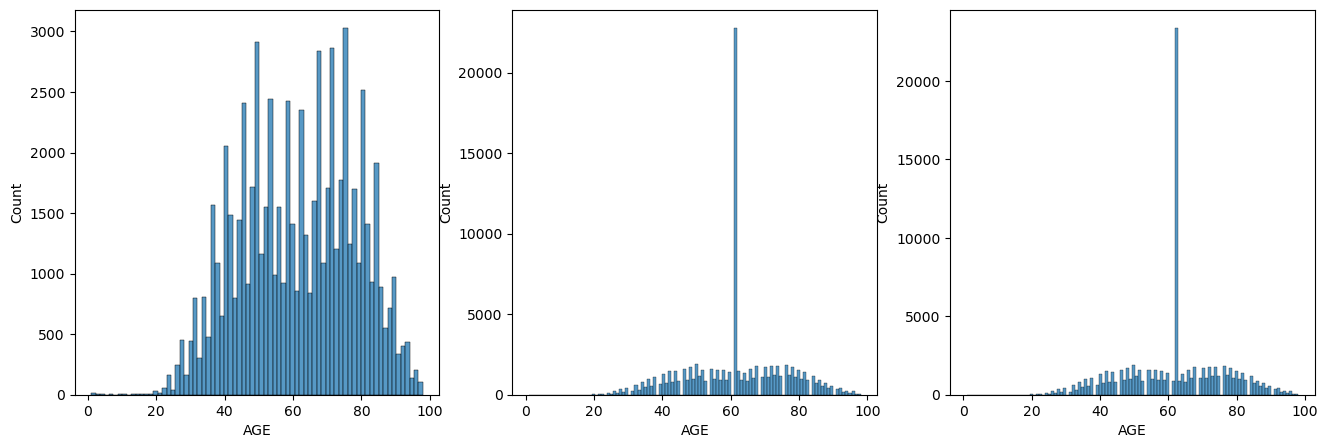

In [83]:
#numerical['AGE'] = numerical["AGE"].fillna(np.mean(numerical['AGE']))
fig, ax = plt.subplots(1,3,figsize=(16,5))
sns.histplot(numerical['AGE'], ax = ax[0])
sns.histplot(numerical["AGE"].fillna(np.mean(numerical[numerical['AGE'].notna()]['AGE'])), ax = ax[1])
sns.histplot(numerical['AGE'].fillna(np.median(numerical[numerical['AGE'].notna()]['AGE'])),ax = ax[2])
plt.show()
numerical['AGE'] = numerical["AGE"].fillna(np.median(numerical['AGE']))

In [ ]:
#indexes_with_na = numerical[numerical['AGE'].isna()].index
#for index in indexes_with_na:
#    x = np.random() # [ 0,1]
#    numerical.iloc[index,list(numerical.columns).index('AGE')] = np.quantile(numerical['AGE'],x)# kde

In [ ]:
import numpy as np

# Get the indexes where 'AGE' is NaN
indexes_with_na = numerical['AGE'].isna()

# Generate random quantiles for each NaN
random_quantiles = np.random.uniform(0, 1, size=indexes_with_na.sum())

# Compute the quantiles in the 'AGE' column
quantiles = numerical['AGE'].dropna().quantile(random_quantiles)

# Fill NaNs with the computed quantiles
numerical.loc[indexes_with_na, 'AGE'] = quantiles.values


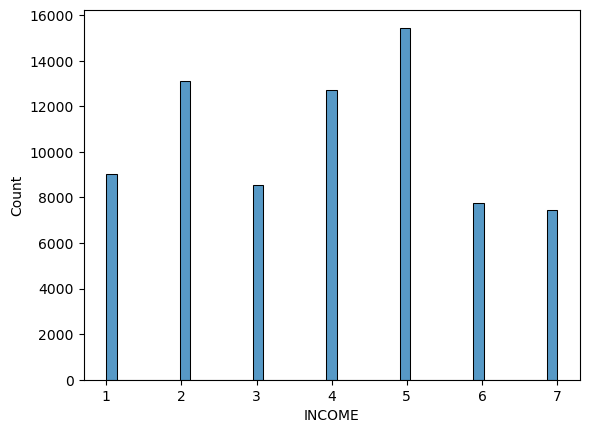

In [84]:
#sns.distplot(numerical['INCOME'])  # this will not work as there are NaNs in the column
sns.histplot(numerical[numerical['INCOME'].notna()]['INCOME'])
plt.show()

In [85]:
# looks like the variable is actually categorical. We can verify it by using value_counts()
print(numerical['INCOME'].value_counts(dropna=False))
#numerical['INCOME'] = numerical['INCOME'].astype('object')

NaN    18329
5.0    15451
2.0    13114
4.0    12732
1.0     9022
3.0     8558
6.0     7778
7.0     7471
Name: INCOME, dtype: int64


In [86]:
m = numerical['INCOME'].mode()[0]
numerical['INCOME'] = numerical['INCOME'].fillna(m) # Replacing the null values with the most represented categoty

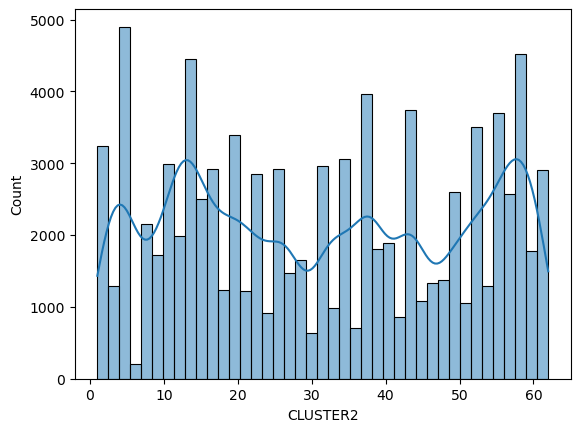

In [87]:
#numerical[numerical['CLUSTER2'].notna()]
sns.histplot(numerical[numerical['CLUSTER2'].isna()==False]['CLUSTER2'],kde=True)
plt.show()

In [88]:
numerical['CLUSTER2'] = numerical['CLUSTER2'].fillna(np.ceil(np.mean(numerical['CLUSTER2'])))

# Activity

Drop all the numerical columns that contain the string "ADATE_" in the column name. We are assuming that the date when the previous mail was done is not significant in the respondents decision to give donation.

In [89]:
num_cols_to_drop = [col for col in list(numerical.columns) if "ADATE_" in col]
num_cols_to_drop

['ADATE_2',
 'ADATE_3',
 'ADATE_4',
 'ADATE_5',
 'ADATE_6',
 'ADATE_7',
 'ADATE_8',
 'ADATE_9',
 'ADATE_10',
 'ADATE_11',
 'ADATE_12',
 'ADATE_13',
 'ADATE_14',
 'ADATE_15',
 'ADATE_16',
 'ADATE_17',
 'ADATE_18',
 'ADATE_19',
 'ADATE_20',
 'ADATE_21',
 'ADATE_22',
 'ADATE_23',
 'ADATE_24']

In [90]:
numerical.drop(columns=num_cols_to_drop, axis = 1, inplace = True)
#numerical = numerical.drop(columns=num_cols_to_drop, axis = 1)

In [ ]:
# End of activity

In [91]:
"ADATE_" in numerical.columns.tolist()

False

#Lab 2

Lab instructions can be found [here](https://github.com/ironhack-labs/lab-feature-engineering)

- Check for null values in the numerical columns.

In [112]:
df = pd.DataFrame(numerical.isna().sum()).reset_index()
df.columns = ['column_name', 'nulls']
df[df['nulls']>0]

,column_name,nulls
3,AGE,6642
14,WEALTH2,21947
316,NEXTDATE,4889
317,TIMELAG,4889


In [109]:
numerical.columns

Index(['ODATEDW', 'TCODE', 'DOB', 'AGE', 'INCOME', 'WEALTH1', 'HIT',
       'MALEMILI', 'MALEVET', 'VIETVETS',
       ...
       'LASTGIFT', 'LASTDATE', 'FISTDATE', 'NEXTDATE', 'TIMELAG', 'AVGGIFT',
       'CONTROLN', 'HPHONE_D', 'RFA_2F', 'CLUSTER2'],
      dtype='object', length=323)

- Use appropriate methods to clean the columns `GEOCODE2`, `WEALTH1`, `ADI`, `DMA`,and `MSA`.
- Use appropriate EDA technique where ever necessary.


In [120]:
categorical['GEOCODE2'].value_counts(dropna=False)

A    18526
B    16495
C     8306
D     7291
Name: GEOCODE2, dtype: int64

In [ ]:
m_index = categorical[categorical['GEOCODE2'].notna()].index.tolist()
categorical = categorical.loc[m_index,:]
numerical = numerical.loc[m_index,:]

In [124]:
numerical['WEALTH1'].isna().sum()/len(numerical)

0.0

In [ ]:
ml = numerical[numerical['WEALTH1'].notna()].index.tolist()
numerical = numerical.loc[ml,:]
categorical = categorical.loc[ml,:]

In [117]:
numerical['ADI'].value_counts(dropna=False)

13.0     3345
51.0     2628
65.0     1910
57.0     1537
197.0    1284
         ... 
601.0       1
139.0       1
145.0       1
161.0       1
651.0       1
Name: ADI, Length: 200, dtype: int64

In [116]:
numerical['ADI'].isna().sum()/len(numerical)

0.0

In [119]:
numerical['DMA'].value_counts(dropna=False)

803.0    3345
602.0    2630
807.0    1910
505.0    1538
524.0    1285
         ... 
584.0       1
598.0       1
538.0       1
502.0       1
552.0       1
Name: DMA, Length: 200, dtype: int64

In [118]:
numerical['DMA'].isna().sum()/len(numerical)

0.0

In [122]:
numerical['MSA'].isna().sum()/len(numerical)

0.0

In [123]:
numerical['MSA'].value_counts(dropna=False)

0.0       9704
1600.0    2307
4480.0    2185
2160.0    1381
520.0     1108
          ... 
1480.0       1
1320.0       1
2281.0       1
1303.0       1
7610.0       1
Name: MSA, Length: 287, dtype: int64

END OF LAB

In [121]:
# Check for null values in the numerical columns.
display(numerical.isna().sum()/len(numerical))

ODATEDW     0.000000
TCODE       0.000000
DOB         0.000000
AGE         0.131218
INCOME      0.000000
              ...   
AVGGIFT     0.000000
CONTROLN    0.000000
HPHONE_D    0.000000
RFA_2F      0.000000
CLUSTER2    0.000000
Length: 323, dtype: float64

In [ ]:
# Use appropriate methods to clean the columns
# categorical: GEOCODE2 (drop rows with NA's)
# numerical: WEALTH1 (drop rows with NA's), ADI, DMA,and MSA.

In [93]:
categorical['GEOCODE2'].value_counts(dropna=False)

A      33315
B      27714
D      16034
C      15091
NaN      301
Name: GEOCODE2, dtype: int64

In [94]:
m_index = categorical[categorical['GEOCODE2'].notna()].index.tolist()
categorical = categorical.loc[m_index,:]
numerical = numerical.loc[m_index,:]

In [ ]:
m_index

In [98]:
categorical

,OSOURCE,STATE,ZIP,MAILCODE,NOEXCH,MDMAUD,CLUSTER,HOMEOWNR,GENDER,DATASRCE,RFA_2R,RFA_2A,GEOCODE2,DOMAIN_A,DOMAIN_B
0,GRI,IL,61081,A,0,XXXX,36,H,F,NaN,L,E,C,T,2
1,BOA,CA,91326,A,0,XXXX,14,H,M,3,L,G,A,S,1
2,AMH,NC,27017,A,0,XXXX,43,U,M,3,L,E,C,R,2
3,BRY,CA,95953,A,0,XXXX,44,U,F,3,L,E,C,R,2
4,NaN,FL,33176,A,0,XXXX,16,H,F,3,L,F,A,S,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,ASE,other,99504,A,0,XXXX,27,H,M,NaN,L,G,C,C,2
95408,DCD,TX,77379,A,0,XXXX,24,H,M,3,L,F,A,C,1
95409,MBC,MI,48910,A,0,XXXX,30,H,M,NaN,L,E,B,C,3
95410,PRV,CA,91320,A,0,XXXX,24,H,F,2,L,F,A,C,1


In [97]:
numerical['WEALTH1'].isna().sum()/len(numerical)

0.45072378844108774

In [100]:
ml = numerical[numerical['WEALTH1'].notna()].index.tolist()
numerical = numerical.loc[ml,:]
categorical = categorical.loc[ml,:]

#Wrapping up

In [101]:
num_columns_to_drop = [col for col in drop_columns_list if col in list(numerical.columns)]
#num_columns_to_drop
numerical = numerical.drop(columns=num_columns_to_drop, axis = 1)

In [102]:
df = pd.DataFrame(numerical.isna().sum()).reset_index()
df.columns = ['column_name', 'nulls']
df[df['nulls']>0]

,column_name,nulls
3,AGE,6642
14,WEALTH2,21947
316,NEXTDATE,4889
317,TIMELAG,4889


In [ ]:
numerical.to_csv('/content/drive/MyDrive/CURR-v3.X-JUN2023/UNIT7/DAY1/7.01, 7.02 Data Cleaning and Feature selection review/numerical7_02.csv')
categorical.to_csv('/content/drive/MyDrive/CURR-v3.X-JUN2023/UNIT7/DAY1/7.01, 7.02 Data Cleaning and Feature selection review/categorical7_02.csv')

In [ ]:
Y.to_csv('/content/drive/MyDrive/CURR-v3.X-JUN2023/UNIT7/DAY1/7.01, 7.02 Data Cleaning and Feature selection review/target7_02.csv')

Pandas can also use pickles.

In [ ]:
numerical.to_pickle('/content/drive/MyDrive/CURR-v3.X-JUL2022/UNIT7/DAY1/7.01, 7.02 Data Cleaning and Feature selection review/numerical7_02.pkl')
categorical.to_pickle('/content/drive/MyDrive/CURR-v3.X-JUL2022/UNIT7/DAY1/7.01, 7.02 Data Cleaning and Feature selection review/categorical7_02.pkl')
Y.to_pickle('/content/drive/MyDrive/CURR-v3.X-JUL2022/UNIT7/DAY1/7.01, 7.02 Data Cleaning and Feature selection review/target7.02.pkl')